In [2]:
import sys
sys.executable

'c:\\Users\\carlo\\miniforge3\\envs\\dtu02452\\python.exe'

In [3]:
from pathlib import Path
import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import pyedflib
from mne.time_frequency import psd_array_welch
from IPython.display import display
from scipy.signal import welch
from scipy.signal import coherence


In [4]:
data = Path(r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\n3.edf")
raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
raw.load_data()
raw.info["sfreq"], len(raw.ch_names), raw.ch_names[:10]

Reading 0 ... 16927231  =      0.000 ... 33060.998 secs...


C:\Users\carlo\AppData\Local\Temp\ipykernel_40804\716928837.py:2: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_40804\716928837.py:2: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(data, preload=False, verbose=False)


(512.0,
 23,
 ['Fp2-F4',
  'F4-C4',
  'C4-P4',
  'P4-O2',
  'F8-T4',
  'T4-T6',
  'FP1-F3',
  'F3-C3',
  'C3-P3',
  'P3-O1'])

In [5]:
print("Sampling frequency:", raw.info["sfreq"])
print("Duration (s):", raw.n_times / raw.info["sfreq"])

Sampling frequency: 512.0
Duration (s): 33061.0


In [6]:
txt_path = r"C:\Users\carlo\OneDrive - Universidade de Lisboa\Documents\GitHub\heart-lung-brain-coupling-for-RBD\Data\cap-sleep-database-1.0.0\rbd1.txt"
df = pd.read_csv(txt_path, sep='\t', header=None, names=["Sleep Stage", "Position", "Time [hh:mm:ss]", "Event", "Duration[s]", "Location"], skiprows=22)
df.head()

,Sleep Stage,Position,Time [hh:mm:ss],Event,Duration[s],Location
0,W,Unknown Position,23:07:19,SLEEP-S0,30,ROC-LOC
1,W,Unknown Position,23:07:49,SLEEP-S0,30,ROC-LOC
2,W,Unknown Position,23:08:19,SLEEP-S0,30,ROC-LOC
3,W,Unknown Position,23:08:49,SLEEP-S0,30,ROC-LOC
4,W,Unknown Position,23:09:19,SLEEP-S0,30,ROC-LOC


In [7]:
import importlib
import functions
importlib.reload(functions)

from functions import compute_stage_epochs, add_epoch_onsets

df = add_epoch_onsets(df, 30.0)

stages = ["W", "R", "S1", "S2", "S3", "S4"]

stage_dfs = {}

for stage in stages:
    stage_dfs[stage] = compute_stage_epochs(df, stage)

stage_dfs["R"][:5]

[(13620.0, 13650.0),
 (13650.0, 13680.0),
 (13680.0, 13710.0),
 (13710.0, 13740.0),
 (13740.0, 13770.0)]

In [8]:
wake_epochs = compute_stage_epochs(df, "W")
rem_epochs  = compute_stage_epochs(df, "R")
S1_epochs   = compute_stage_epochs(df, "S1")
S2_epochs   = compute_stage_epochs(df, "S2")
S3_epochs   = compute_stage_epochs(df, "S3")
S4_epochs   = compute_stage_epochs(df, "S4")

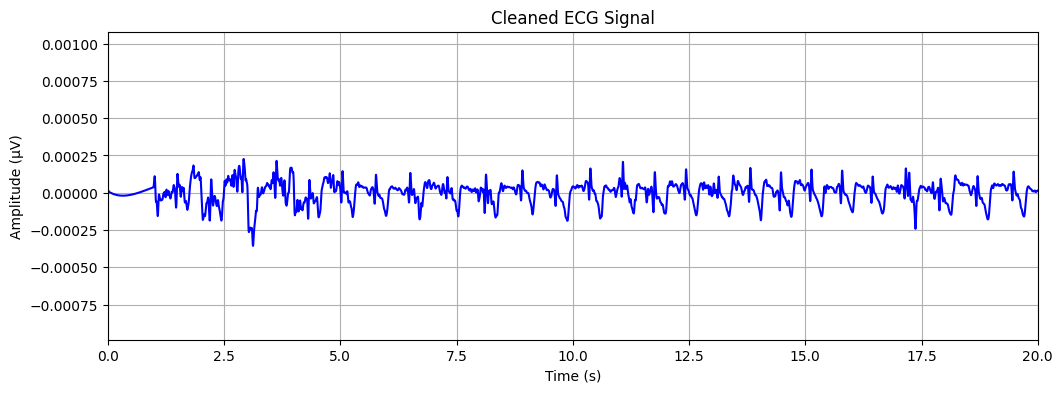

In [9]:
import functions
from functions import preprocess_ecg

ecg_clean = preprocess_ecg(raw)
sf = raw.info["sfreq"]

fig, ax = plt.subplots(figsize=(12, 4))
time = np.arange(len(ecg_clean)) / sf
ax.plot(time, ecg_clean, color='blue')
ax.set_title("Cleaned ECG Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (µV)")
ax.set_xlim(0, 20) 
ax.grid()
plt.show()

In [10]:
import importlib
import functions
importlib.reload(functions)

from functions import extract_ecg_per_epoch

ecg_R  = extract_ecg_per_epoch(ecg_clean, ecg_clean, rem_epochs, sf)
ecg_S1 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S1_epochs, sf)
ecg_S2 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S2_epochs, sf)
ecg_S3 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S3_epochs, sf)
ecg_S4 = extract_ecg_per_epoch(ecg_clean, ecg_clean, S4_epochs, sf)
ecg_W  = extract_ecg_per_epoch(ecg_clean, ecg_clean, wake_epochs, sf)

In [11]:
ecg_R["hr_mean_bpm"].mean()
ecg_S2["hr_mean_bpm"].mean()

np.float64(61.902793822939095)

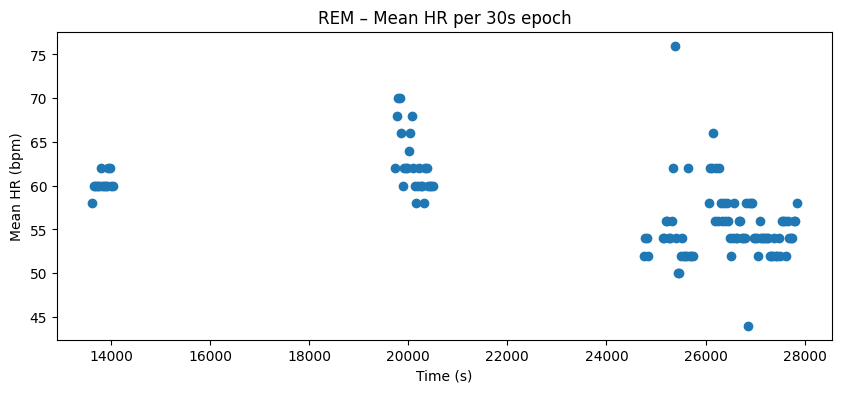

In [12]:
plt.figure(figsize=(10,4))
plt.scatter(ecg_R["t0_s"], ecg_R["hr_mean_bpm"])
plt.xlabel("Time (s)")
plt.ylabel("Mean HR (bpm)")
plt.title("REM – Mean HR per 30s epoch")
plt.show()

In [13]:
import importlib
import functions
importlib.reload(functions)

from functions import hrv_per_epoch

hrv_rem = hrv_per_epoch(ecg_clean, rem_epochs, sf)

hrv_s1 = hrv_per_epoch(ecg_clean, S1_epochs, sf)

hrv_s2 = hrv_per_epoch(ecg_clean, S2_epochs, sf)

hrv_s3 = hrv_per_epoch(ecg_clean, S3_epochs, sf)

hrv_s4 = hrv_per_epoch(ecg_clean, S4_epochs, sf)

hrv_wake = hrv_per_epoch(ecg_clean, wake_epochs, sf)

for name, df_ in [
    ("REM", hrv_rem),
    ("S1",  hrv_s1),
    ("S2",  hrv_s2),
    ("S3",  hrv_s3),
    ("S4",  hrv_s4),
    ("WAKE", hrv_wake),
]:
    display(df_.head(10).style.set_caption(f"HRV per epoch — {name}").format(precision=3))


c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packages\neurokit2\signal\signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
c:\Users\carlo\miniforge3\envs\dtu02452\Lib\site-packag

,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok
0,0,13620.000,59.890,41.633,43.154,28.571,29,True
1,1,13650.000,61.240,25.053,21.103,3.448,30,True
2,2,13680.000,61.287,28.901,29.766,6.897,30,True
3,3,13710.000,61.808,25.143,21.026,3.448,30,True
4,4,13740.000,62.146,26.876,19.169,0.000,30,True
5,5,13770.000,61.347,27.671,25.871,10.345,30,True
6,6,13800.000,60.947,26.414,21.952,3.333,31,True
7,7,13830.000,61.407,28.988,30.271,6.897,30,True
8,8,13860.000,62.192,22.917,20.172,0.000,30,True
9,9,13890.000,61.817,24.763,25.724,0.000,30,True


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok,error
0,0,690.000,68.394,33.887,33.003,15.625,33.000,True,nan
1,1,720.000,69.320,28.255,27.658,6.061,34.000,True,nan
2,2,750.000,67.949,131.727,149.254,15.152,34.000,True,nan
3,3,780.000,77.328,25.208,26.617,12.500,9.000,True,nan
4,4,1170.000,66.751,102.516,75.780,31.250,33.000,True,nan
5,5,1260.000,69.620,59.399,68.734,27.273,34.000,True,nan
6,6,4320.000,60.527,30.249,24.292,6.897,30.000,True,nan
7,7,4350.000,60.811,24.000,21.132,0.000,7.000,True,nan
8,8,4380.000,60.666,26.594,18.559,0.000,30.000,True,nan
9,9,4410.000,60.678,27.503,20.269,0.000,9.000,True,nan


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok,error
0,0,810.000,66.031,28.386,22.863,0.000,32.000,True,nan
1,1,840.000,74.190,33.501,31.654,16.667,7.000,True,nan
2,2,870.000,76.819,10.749,16.289,0.000,9.000,True,nan
3,3,900.000,67.713,25.449,27.298,3.125,33.000,True,nan
4,4,930.000,68.144,38.148,29.704,0.000,6.000,True,nan
5,5,1200.000,64.598,35.374,43.661,19.355,32.000,True,nan
6,6,1230.000,70.507,326.037,275.149,51.852,28.000,True,nan
7,7,1290.000,69.857,68.934,84.745,14.706,35.000,True,nan
8,8,1320.000,65.872,20.645,16.617,0.000,13.000,True,nan
9,9,1350.000,74.267,48.537,91.618,11.111,37.000,True,nan


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok
0,0,1560.000,65.797,98.490,86.142,38.710,32,True
1,1,1590.000,65.823,37.817,34.552,15.625,33,True
2,2,1620.000,67.190,24.473,18.037,0.000,11,True
3,3,1650.000,69.466,32.367,37.405,11.111,10,True
4,4,1680.000,64.794,38.596,45.202,16.129,32,True
5,5,1710.000,66.810,40.910,38.046,16.667,13,True
6,6,1740.000,71.643,109.992,166.796,20.588,35,True
7,7,1770.000,63.726,17.812,20.217,0.000,8,True
8,8,1800.000,66.546,32.692,37.682,15.385,14,True
9,9,1830.000,65.657,26.690,22.459,3.125,33,True


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok
0,0,1890.000,66.523,32.200,23.767,6.250,33,True
1,1,1920.000,68.377,31.077,43.495,15.789,20,True
2,2,1950.000,67.630,37.998,63.684,12.121,34,True
3,3,1980.000,63.093,38.042,43.699,10.000,31,True
4,4,2010.000,64.421,21.501,16.707,0.000,13,True
5,5,2040.000,63.151,29.689,30.782,6.667,31,True
6,6,2070.000,64.170,39.432,47.593,19.355,32,True
7,7,2100.000,75.245,23.462,60.444,2.703,38,True
8,8,2130.000,71.150,29.580,25.999,11.111,10,True
9,9,2160.000,61.677,31.595,24.711,13.333,31,True


,epoch,start_s,hr_mean_bpm,rmssd_ms,sdnn_ms,pnn50_pct,n_beats,ok
0,0,0.000,81.923,44.029,64.146,10.256,40,True
1,1,30.000,82.724,80.656,100.110,28.205,40,True
2,2,60.000,84.796,97.882,102.252,7.317,42,True
3,3,90.000,95.457,139.527,144.620,4.348,47,True
4,4,120.000,77.820,247.025,238.762,18.919,38,True
5,5,150.000,80.637,403.467,343.351,67.568,38,True
6,6,180.000,79.657,32.857,55.663,15.789,39,True
7,7,210.000,67.358,47.571,55.140,12.500,33,True
8,8,240.000,71.396,117.209,98.053,29.412,35,True
9,9,270.000,77.955,159.439,108.501,37.838,38,True


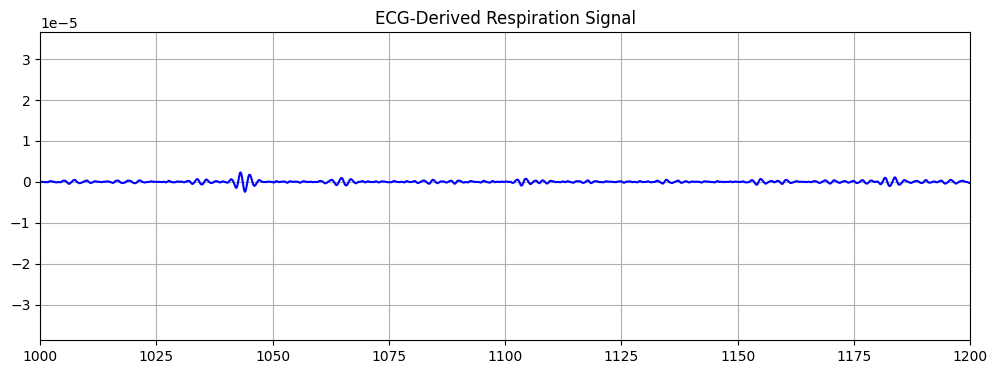

In [14]:
import importlib
import functions
importlib.reload(functions)

from functions import hpc_metric, extract_resp_from_ecg

resp = extract_resp_from_ecg(ecg_clean, sf)

fig, ax = plt.subplots(figsize=(12, 4))
time = np.arange(len(resp)) / sf
ax.plot(time, resp, color='blue')
ax.set_title("ECG-Derived Respiration Signal")
ax.set_xlim(1000, 1200) 
ax.grid()
plt.show()


HPC ANLYSIS

In [15]:
import importlib
import functions
importlib.reload(functions)
from functions import hpc_metric, extract_resp_from_ecg


hpc_s1 = hpc_metric(ecg_clean, resp, S1_epochs, sf, window_epochs=3)
hpc_s2 = hpc_metric(ecg_clean, resp, S2_epochs, sf, window_epochs=3)
hpc_s3 = hpc_metric(ecg_clean, resp, S3_epochs, sf, window_epochs=3)
hpc_s4 = hpc_metric(ecg_clean, resp, S4_epochs, sf, window_epochs=3)
hpc_rem = hpc_metric(ecg_clean, resp, rem_epochs, sf, window_epochs=3)
hpc_wake = hpc_metric(ecg_clean, resp, wake_epochs, sf, window_epochs=3)

print("\nREM Table:")
print(hpc_rem.head())
print("\nWake Table:")
print(hpc_wake.head())
print("S1 Table:")
print(hpc_s1.head())
print("\nS2 Table:")
print(hpc_s2.head())
print("\nS3 Table:")
print(hpc_s3.head())
print("\nS4 Table:")
print(hpc_s4.head())



REM Table:
   epoch           HFC           LFC   LFC/HFC    ok
0      0  2.092396e-11  5.808359e-14  0.002776  True
1      3  4.164816e-11  8.334595e-14  0.002001  True
2      6  3.475907e-11  9.778974e-13  0.028134  True
3      9  3.784282e-11  5.304500e-13  0.014017  True
4     12  4.341444e-11  6.650781e-13  0.015319  True

Wake Table:
   epoch           HFC           LFC   LFC/HFC    ok
0      0  2.273924e-09  3.009225e-10  0.132336  True
1      3  2.735520e-09  5.609006e-11  0.020504  True
2      6  1.775093e-09  1.979136e-11  0.011149  True
3      9  6.978053e-10  1.458945e-11  0.020908  True
4     12  1.541373e-10  1.100169e-12  0.007138  True
S1 Table:
   epoch           HFC           LFC   LFC/HFC    ok
0      0  3.264321e-10  6.309057e-12  0.019327  True
1      3  4.485217e-11  8.997309e-12  0.200599  True
2      6  3.056940e-10  3.463318e-13  0.001133  True
3      9  2.812178e-10  4.401134e-14  0.000157  True
4     12  2.843274e-10  8.733581e-13  0.003072  True

S2 Table:


In [16]:
from functions import classify_sleep_stable_unstable

hpc_rem = classify_sleep_stable_unstable(hpc_rem)
hpc_s1 = classify_sleep_stable_unstable(hpc_s1)
hpc_s2 = classify_sleep_stable_unstable(hpc_s2)
hpc_s3 = classify_sleep_stable_unstable(hpc_s3)
hpc_s4 = classify_sleep_stable_unstable(hpc_s4)
hpc_wake = classify_sleep_stable_unstable(hpc_wake)


print("\nREM Table:")
print(hpc_rem.head())
print(hpc_rem["sleep_stability"].value_counts(normalize=True))

print("\nS1 Table:")
print(hpc_s1.head())
print(hpc_s1["sleep_stability"].value_counts(normalize=True))

print("\nS2 Table:")
print(hpc_s2.head())
print(hpc_s2["sleep_stability"].value_counts(normalize=True))

print("\nS3 Table:")
print(hpc_s3.head())
print(hpc_s3["sleep_stability"].value_counts(normalize=True))

print("\nS4 Table:")
print(hpc_s4.head())
print(hpc_s4["sleep_stability"].value_counts(normalize=True))

print("\nWake Table:")
print(hpc_wake.head())
print(hpc_wake["sleep_stability"].value_counts(normalize=True))


REM Table:
   epoch           HFC           LFC   LFC/HFC    ok sleep_stability
0      0  2.092396e-11  5.808359e-14  0.002776  True          stable
1      3  4.164816e-11  8.334595e-14  0.002001  True          stable
2      6  3.475907e-11  9.778974e-13  0.028134  True          stable
3      9  3.784282e-11  5.304500e-13  0.014017  True          stable
4     12  4.341444e-11  6.650781e-13  0.015319  True          stable
sleep_stability
stable      0.97619
unstable    0.02381
Name: proportion, dtype: float64

S1 Table:
   epoch           HFC           LFC   LFC/HFC    ok sleep_stability
0      0  3.264321e-10  6.309057e-12  0.019327  True          stable
1      3  4.485217e-11  8.997309e-12  0.200599  True          stable
2      6  3.056940e-10  3.463318e-13  0.001133  True          stable
3      9  2.812178e-10  4.401134e-14  0.000157  True          stable
4     12  2.843274e-10  8.733581e-13  0.003072  True          stable
sleep_stability
stable    1.0
Name: proportion, dtype: float

In [21]:
print(hpc_rem.columns)

Index(['epoch', 'HFC', 'LFC', 'LFC/HFC', 'ok', 'sleep_stability'], dtype='object')


C:\Users\carlo\AppData\Local\Temp\ipykernel_40804\538305750.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


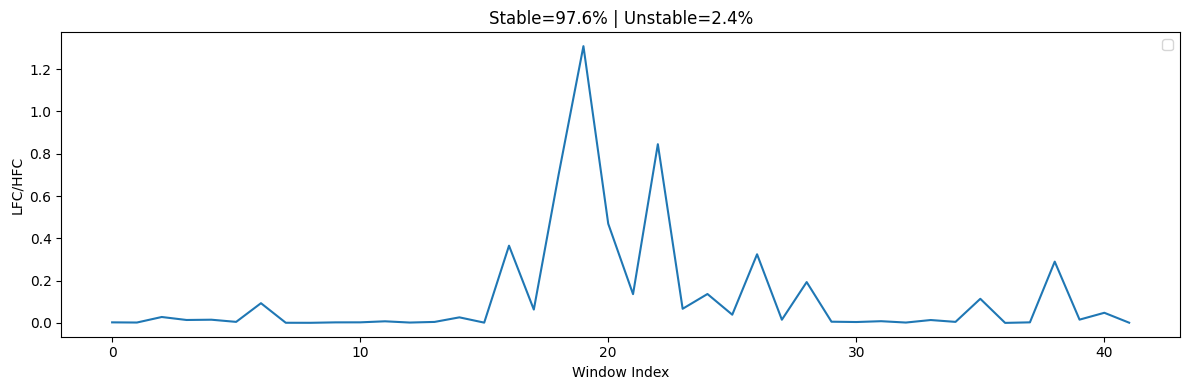

In [ ]:
stable_pct = (hpc_rem["sleep_stability"] == "stable").mean() * 100
unstable_pct = (hpc_rem["sleep_stability"] == "unstable").mean() * 100

plt.figure(figsize=(12,4))
plt.plot(np.arange(len(hpc_rem)), hpc_rem["LFC/HFC"], linewidth=1.5)
plt.xlabel("Window Index")
plt.ylabel("LFC/HFC")
plt.title(f"Stable={stable_pct:.1f}% | Unstable={unstable_pct:.1f}%")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(len(hpc_rem))
print(len(hpc_s1))
print(len(hpc_s2))
print(len(hpc_s3))
print(len(hpc_s4))
print(len(hpc_wake))

42
17
157
20
48
24


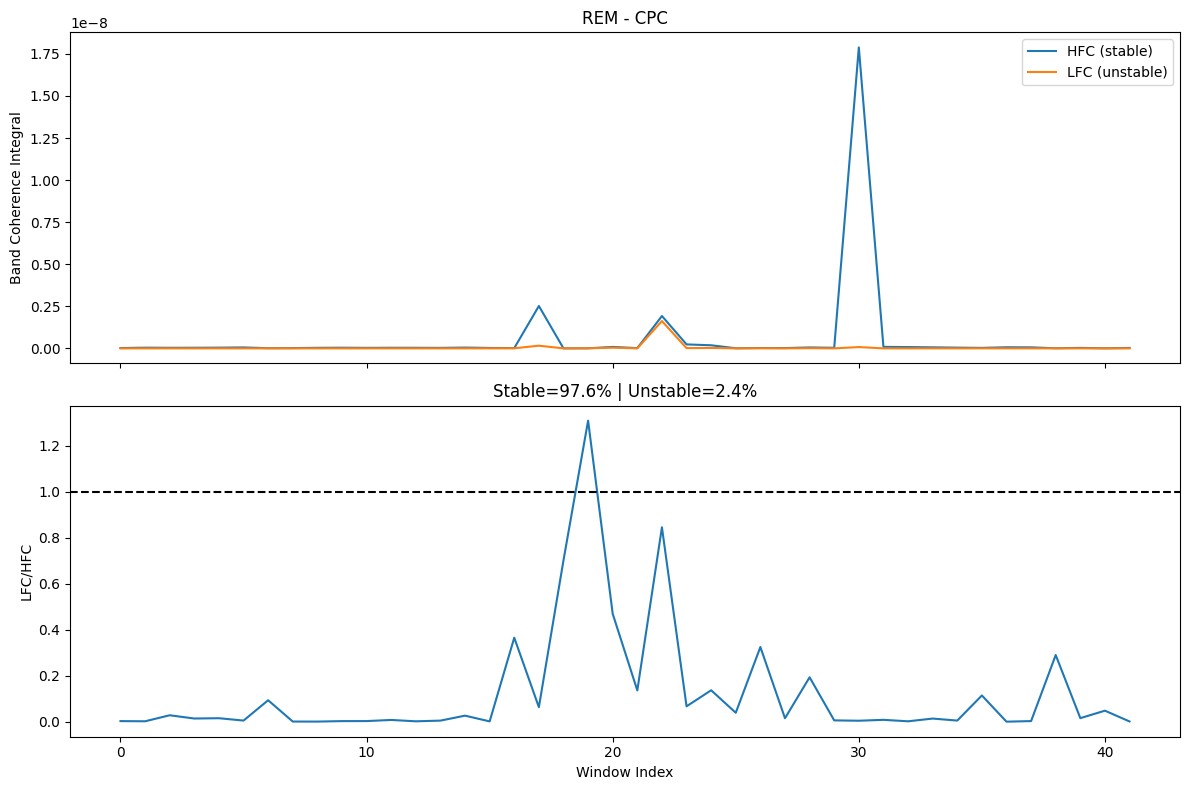

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# --- HFC vs LFC ---
axes[0].plot(np.arange(len(hpc_rem)), hpc_rem["HFC"], label="HFC (stable)")
axes[0].plot(np.arange(len(hpc_rem)), hpc_rem["LFC"], label="LFC (unstable)")
axes[0].set_ylabel("Band Coherence Integral")
axes[0].set_title("REM - CPC")
axes[0].legend()

# --- Ratio ---
axes[1].plot(np.arange(len(hpc_rem)), hpc_rem["LFC/HFC"])
axes[1].axhline(1.0, linestyle="--", color="black")
axes[1].set_ylabel("LFC/HFC")
axes[1].set_xlabel("Window Index")
axes[1].set_title(f"Stable={stable_pct:.1f}% | Unstable={unstable_pct:.1f}%")

plt.tight_layout()
plt.show()